# **Graph Workflows**

## **What's Covered?**
1. Parallel Graph

## **Parallel Graph**

In [1]:
# Step 1: Defining a State
from typing import TypedDict, List

# Define a typed state
class AnalyticsState(TypedDict):
    values: List[float]
    average: float
    minimum: float
    summary: str

In [2]:
# Step 2: Defining graph nodes

def avg_calculator(state: AnalyticsState):
    """This function calculates the average."""
    values = state['values']
    avg = sum(values)/len(values)
    return {"average" : avg}

def min_calculator(state: AnalyticsState):
    """This function calculates the min value."""
    values = state['values']
    minimum = min(values)
    return {"minimum" : minimum}    

def summary(state: AnalyticsState):
    """This function compiles the summary analytics."""
    summary = f"""-- Summary Analytics --
    Values: {state["values"]}
    Average: {state["average"]}
    Minimum: {state["minimum"]}"""

    return {"summary": summary}

In [3]:
# Step 3: Define a Graph

from langgraph.graph import StateGraph, START, END

graph = StateGraph(AnalyticsState)

graph.add_node("avg_calculator_node", avg_calculator)
graph.add_node("min_calculator_node", min_calculator)
graph.add_node("summary_node", summary)

graph.add_edge(START, "avg_calculator_node")
graph.add_edge(START, "min_calculator_node")
graph.add_edge("avg_calculator_node", "summary_node")
graph.add_edge("min_calculator_node", "summary_node")
graph.add_edge("summary_node", END)

In [4]:
# Step 4: Compile the graph

workflow = graph.compile()

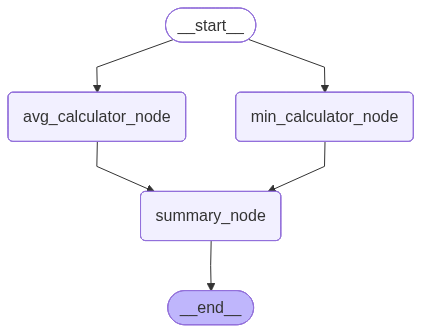

In [5]:
# Visualize the Graph

from IPython.display import Image, display

display(Image(workflow.get_graph().draw_mermaid_png()))

In [6]:
workflow.invoke({"values": [5, -1, 0, 2, 9]})

{'values': [5, -1, 0, 2, 9],
 'average': 3.0,
 'minimum': -1,
 'summary': '-- Summary Analytics --\n    Values: [5, -1, 0, 2, 9]\n    Average: 3.0\n    Minimum: -1'}

## **Example**

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Initialize the Model (We use a fast model for this demo)
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)

# --- WORKER 1: THE COPYWRITER ---
# Goal: Write engaging text.
copy_prompt = ChatPromptTemplate.from_template(
    """You are a senior social media copywriter. 
    Write a catchy LinkedIn post about: {topic}.
    Use emojis, bullet points, and a professional yet exciting tone.
    Keep it under 100 words."""
)
copy_chain = copy_prompt | llm | StrOutputParser()

# --- WORKER 2: THE ART DIRECTOR ---
# Goal: Create technical instructions for an image generator.
art_prompt = ChatPromptTemplate.from_template(
    """You are an expert AI Art Director. 
    Create a highly detailed Midjourney prompt to generate an image for this topic: {topic}.
    Include details about lighting, camera angle, artistic style (e.g., Cyberpunk, Minimalist), and aspect ratio."""
)
art_chain = art_prompt | llm | StrOutputParser()

# --- WORKER 3: THE STRATEGIST ---
# Goal: Analyze timing and tagging.
strategy_prompt = ChatPromptTemplate.from_template(
    """You are a Social Media Strategist.
    For the topic '{topic}', provide:
    1. The best time to post (Day & Time).
    2. A list of 5 high-traffic hashtags.
    3. The target audience persona.
    Return this as a clean summary."""
)
strategy_chain = strategy_prompt | llm | StrOutputParser()

In [ ]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

# Define the State (The Folder that gets passed around)
class CampaignState(TypedDict):
    topic: str              # Input
    post_caption: str       # Output 1
    image_instruction: str  # Output 2
    strategy_brief: str     # Output 3
    final_package: str      # The Aggregated Result

# --- DEFINE NODES ---

def copywriter_node(state: CampaignState):
    print("   ✍️ [Copywriter] Drafting content...")
    result = copy_chain.invoke({"topic": state["topic"]})
    return {"post_caption": result}

def art_director_node(state: CampaignState):
    print("   🎨 [Art Director] Designing visuals...")
    result = art_chain.invoke({"topic": state["topic"]})
    return {"image_instruction": result}

def strategist_node(state: CampaignState):
    print("   📊 [Strategist] Analyzing trends...")
    result = strategy_chain.invoke({"topic": state["topic"]})
    return {"strategy_brief": result}

# --- THE AGGREGATOR NODE (The "Publisher") ---
# This runs AFTER the parallel workers. It sees the FULL populated state.
def publisher_node(state: CampaignState):
    print("   ✅ [Publisher] Compiling final report...")
    
    # It reads all the separate outputs
    caption = state["post_caption"]
    visuals = state["image_instruction"]
    strategy = state["strategy_brief"]
    
    # It combines them into one final string
    final_report = (
        f"--- CAMPAIGN REPORT: {state['topic'].upper()} ---\n\n"
        f"1. VISUAL PROMPT:\n{visuals}\n\n"
        f"2. CAPTION DRAFT:\n{caption}\n\n"
        f"3. STRATEGY:\n{strategy}"
    )
    return {"final_package": final_report}

# --- BUILD GRAPH ---
builder = StateGraph(CampaignState)

# Add Nodes
builder.add_node("copywriter", copywriter_node)
builder.add_node("art_director", art_director_node)
builder.add_node("strategist", strategist_node)
builder.add_node("publisher", publisher_node)

# Parallel Fan-Out (Start -> 3 Workers)
builder.add_edge(START, "copywriter")
builder.add_edge(START, "art_director")
builder.add_edge(START, "strategist")

# Fan-In (3 Workers -> Publisher)
builder.add_edge("copywriter", "publisher")
builder.add_edge("art_director", "publisher")
builder.add_edge("strategist", "publisher")

# End
builder.add_edge("publisher", END)

app = builder.compile()

In [ ]:
# Execution
inputs = {"topic": "Remote Work for Software Engineers"}
output = app.invoke(inputs)

print(output["final_package"])